In [ ]:
import numpy as np
import scipy.linalg
import scipy.integrate
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
def solve_symmetric_ode_system_linsolve(Lambda, F):
    """
    実対称行列の発展方程式 F = dLambda + [H, Lambda] を、
    H と dLambda の独立成分に関する連立一次方程式として厳密に解く。

    Args:
        Lambda (np.ndarray): n x n の対角固有値行列。
        F (np.ndarray): n x n の対称行列 (Q^T * dA * Q)。

    Returns:
        tuple[np.ndarray, np.ndarray]: (H, dLambda_diag) のタプル。
                                       H は歪対称行列。
                                       dLambda_diag は固有値の変化率（対角成分のみのベクトル）。
    """
    n = Lambda.shape[0]

    # 1. 未知数の数を定義
    num_h_unknowns = n * (n - 1) // 2
    num_dlambda_unknowns = n
    total_unknowns = num_h_unknowns + num_dlambda_unknowns

    # 2. 連立一次方程式 M*x = b を構成
    M = np.zeros((total_unknowns, total_unknowns))
    b = np.zeros(total_unknowns)

    lambdas = np.diag(Lambda)

    # Numpyのインデックス機能を使い、手動ループを避ける
    # eq_indices は上三角部分(対角含む)のインデックス (r, c) r<=c
    # h_indices は厳密に上三角部分のインデックス (r, c) r<c
    eq_indices_r, eq_indices_c = np.triu_indices(n)
    h_indices_r, h_indices_c = np.triu_indices(n, k=1)

    # b ベクトルを構成 (Fの上三角成分)
    b[:num_dlambda_unknowns] = np.diag(F) # 対角成分 (n個)
    b[num_dlambda_unknowns:] = F[h_indices_r, h_indices_c] # 非対角成分 (n(n-1)/2個)

    # 係数行列 M を構成 (Mは対角行列になる)
    # dLambdaに対応するブロック (係数は常に1)
    M_diag = np.ones(total_unknowns)

    # Hに対応するブロック (係数は lambda_j - lambda_i)
    lambda_diffs = lambdas[h_indices_c] - lambdas[h_indices_r]
    M_diag[num_dlambda_unknowns:] = lambda_diffs

    np.fill_diagonal(M, M_diag)

    # 3. 連立一次方程式を解く
    # lstsq は悪条件（固有値の接近）に対して頑健
    # x, residuals, rank, s = np.linalg.lstsq(M, b, rcond=None)
    x = np.linalg.lstsq(M, b, rcond=None)[0]

    # 4. 解ベクトル x を H と dLambda に再構成
    dLambda_diag = x[:num_dlambda_unknowns]
    H_upper_vals = x[num_dlambda_unknowns:]

    H = np.zeros((n, n))
    H[h_indices_r, h_indices_c] = H_upper_vals
    H[h_indices_c, h_indices_r] = -H_upper_vals

    return H, dLambda_diag

def symmetric_ode_derivative(t, y, n, dA_func):
    """
    solve_ivp に渡すための微分方程式の右辺 f(t, y) を定義する。
    y は [Q.flatten(), diag(Lambda)] を連結したベクトル。
    """
    # 1. 状態ベクトルを行列 Q と対角行列 Lambda に復元
    Q = y[:n*n].reshape((n, n))
    lambdas = y[n*n:]
    Lambda = np.diag(lambdas)

    # 2. dA/dt と F を計算
    dA = dA_func(t)
    F = Q.T @ dA @ Q

    # 3. H と dLambda を計算
    H, dLambda_diag = solve_symmetric_ode_system_linsolve(Lambda, F)

    # 4. dQ/dt を計算
    dQ = Q @ H

    # 5. 結果を平坦化して単一のベクトルとして返す
    dydt = np.concatenate([dQ.flatten(), dLambda_diag])
    return dydt

def track_eigen_decomposition(A_func, dA_func, t_span, t_eval, rtol=1e-5, atol=1e-8):
    """
    実対称行列関数 A(t) の固有値分解を、常微分方程式を解くことで追跡する。

    Args:
        A_func (callable): 時刻 t を受け取り、行列 A(t) を返す関数。
        dA_func (callable): 時刻 t を受け取り、行列の微分 dA/dt を返す関数。
        t_span (tuple): 計算を開始・終了する時刻 (t_start, t_end)。
        t_eval (np.ndarray): 結果を評価する時刻の配列。
        rtol (float): solve_ivp用の相対許容誤差。
        atol (float): solve_ivp用の絶対許容誤差。

    Returns:
        tuple: (list[np.ndarray], list[np.ndarray], object)
               - Qs: 各評価時刻における直交固有ベクトル行列 Q のリスト。
               - Lambdas: 各評価時刻における対角固有値行列 Lambda のリスト。
               - sol: scipy.integrate.solve_ivp から返された結果オブジェクト。
    """
    t0 = t_span[0]
    A0 = A_func(t0)
    n = A0.shape[0]

    # 初期条件: eighは実対称行列用に最適化されており、固有値と直交行列を返す
    lambdas0, Q0 = scipy.linalg.eigh(A0)

    # 固有値と固有ベクトルをソートして、追跡中の順序を一定に保つ
    sort_indices = np.argsort(lambdas0)
    lambdas0 = lambdas0[sort_indices]
    Q0 = Q0[:, sort_indices]

    # 初期状態ベクトル y0 を作成
    y0 = np.concatenate([Q0.flatten(), lambdas0])

    # 高精度ソルバーの呼び出し (DOP853は高次のRunge-Kutta法)
    sol = scipy.integrate.solve_ivp(
        symmetric_ode_derivative,
        t_span,
        y0,
        method='DOP853',
        t_eval=t_eval,
        args=(n, dA_func),
        rtol=rtol,
        atol=atol,
        dense_output=True
    )
    if not sol.success:
        raise RuntimeError(f"Integration failed. {sol.message=}")

    # 結果をリストに復元
    actual_t = sol.t
    Qs = [sol_y[:n*n].reshape((n, n)) for sol_y in sol.y.T]
    Lambdas = [np.diag(sol_y[n*n:]) for sol_y in sol.y.T]

    return Qs, Lambdas, sol

In [ ]:
# 1. テスト用の行列を準備
G = nx.complete_bipartite_graph(5, 3)
D = np.array(nx.floyd_warshall_numpy(G))
print("Graph Distance Matrix D:\n", D)

# 2. 追跡対象の行列関数 A(t) とその導関数 dA/dt を定義
# 注意: np.expは「成分ごと」の指数関数
A_func = lambda t: np.exp(-t * D)
# 成分ごとの関数の微分は、連鎖律から成分ごとの積になる
dA_func = lambda t: -D * np.exp(-t * D)

# 3. 追跡を実行
t_start, t_end = 2.0, 1.0e-2
t_eval = np.linspace(t_start, t_end, 250)

print("\nStarting symmetric eigen-decomposition tracking...")
Qs, Lambdas, sol = track_eigen_decomposition(
    A_func, dA_func, (t_start, t_end), t_eval, rtol=1e-10, atol=1e-8
)
print("Tracking finished successfully.")

# 4. 結果の検証と可視化
actual_t_eval = sol.t
eigenvalues_traces = np.array([np.diag(L) for L in Lambdas])

# 最終ステップでのHの歪対称性をチェック
F_final = Qs[-1].T @ dA_func(actual_t_eval[-1]) @ Qs[-1]
H_final, _ = solve_symmetric_ode_system_linsolve(Lambdas[-1], F_final)
symmetry_error = np.linalg.norm(H_final + H_final.T, 'fro')
print(f"Final H skew-symmetry error ||H + H^T||_F: {symmetry_error:.2e}")

Graph Distance Matrix D:
 [[0. 2. 2. 2. 2. 1. 1. 1.]
 [2. 0. 2. 2. 2. 1. 1. 1.]
 [2. 2. 0. 2. 2. 1. 1. 1.]
 [2. 2. 2. 0. 2. 1. 1. 1.]
 [2. 2. 2. 2. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 2. 2.]
 [1. 1. 1. 1. 1. 2. 0. 2.]
 [1. 1. 1. 1. 1. 2. 2. 0.]]

Starting symmetric eigen-decomposition tracking...
Tracking finished successfully.
Final H skew-symmetry error ||H + H^T||_F: 0.00e+00


In [ ]:
# ゼロ固有値検出
zero_indices = []
for i in range(D.shape[0]):
    lambda_i = eigenvalues_traces[:, i]
    if np.amin(lambda_i) < 0.0 < np.amax(lambda_i):
        zero_indices.append(i)

print(f"{zero_indices=}")

zero_indices=[0]


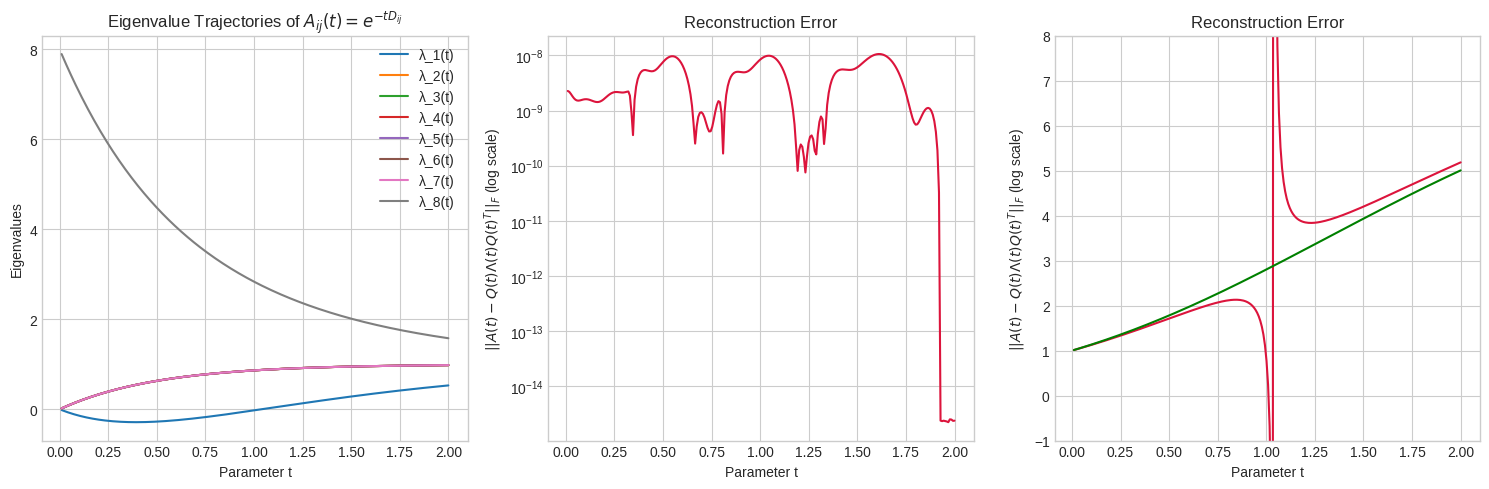


Final reconstruction error at t=0.0100: 2.26e-09


In [ ]:
# 検証: A(t) と Q(t)Lambda(t)Q(t)^T の差のノルムを計算
errors = []
magnitudes = []
pseudo_magnitudes = []
for i, t in enumerate(actual_t_eval):
    A_t = A_func(t)
    reconstructed_A = Qs[i] @ Lambdas[i] @ Qs[i].T
    error = np.linalg.norm(A_t - reconstructed_A, 'fro')
    errors.append(error)
    Lambda_inverse = np.linalg.inv(Lambdas[i])
    v = Qs[i].T @ np.ones(D.shape[0])
    mag_A = v.T @ Lambda_inverse @ v
    magnitudes.append(mag_A)
    Lambda_inverse[zero_indices, zero_indices] = 0
    pseudo_mag_A = v.T @ Lambda_inverse @ v
    pseudo_magnitudes.append(pseudo_mag_A)

# --- プロット ---
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(15, 5))

# 固有値の軌跡をプロット
ax1 = fig.add_subplot(1, 3, 1)
for i in range(D.shape[0]):
    ax1.plot(actual_t_eval, eigenvalues_traces[:, i], label=f'λ_{i+1}(t)')
ax1.set_title('Eigenvalue Trajectories of $A_{ij}(t) = e^{-t D_{ij}}$')
ax1.set_xlabel('Parameter t')
ax1.set_ylabel('Eigenvalues')
ax1.legend()
ax1.grid(True)

# 誤差をプロット
ax2 = fig.add_subplot(1, 3, 2)
ax2.semilogy(actual_t_eval, errors, color='crimson')
ax2.set_title('Reconstruction Error')
ax2.set_xlabel('Parameter t')
ax2.set_ylabel(r'$||A(t) - Q(t)\Lambda(t)Q(t)^T||_F$ (log scale)')
ax2.grid(True)

# 誤差をプロット
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(actual_t_eval, magnitudes, color='crimson')
ax3.plot(actual_t_eval, pseudo_magnitudes, color='green')
ax3.set_title('Reconstruction Error')
ax3.set_xlabel('Parameter t')
ax3.set_ylabel(r'$||A(t) - Q(t)\Lambda(t)Q(t)^T||_F$ (log scale)')
ax3.set_ylim(-1, np.ceil(max(pseudo_magnitudes)) + 2)
ax3.grid(True)

plt.tight_layout()
plt.show()
print(f"\nFinal reconstruction error at t={actual_t_eval[-1]:.4f}: {errors[-1]:.2e}")

Quintipartite Graph Distance Matrix D:
 [[0.  2.  1.  1.  2.5 2.5 4.5 4.5 7.  7. ]
 [2.  0.  1.  1.  2.5 2.5 4.5 4.5 7.  7. ]
 [1.  1.  0.  2.  1.5 1.5 3.5 3.5 6.  6. ]
 [1.  1.  2.  0.  1.5 1.5 3.5 3.5 6.  6. ]
 [2.5 2.5 1.5 1.5 0.  3.  2.  2.  4.5 4.5]
 [2.5 2.5 1.5 1.5 3.  0.  2.  2.  4.5 4.5]
 [4.5 4.5 3.5 3.5 2.  2.  0.  4.  2.5 2.5]
 [4.5 4.5 3.5 3.5 2.  2.  4.  0.  2.5 2.5]
 [7.  7.  6.  6.  4.5 4.5 2.5 2.5 0.  5. ]
 [7.  7.  6.  6.  4.5 4.5 2.5 2.5 5.  0. ]]


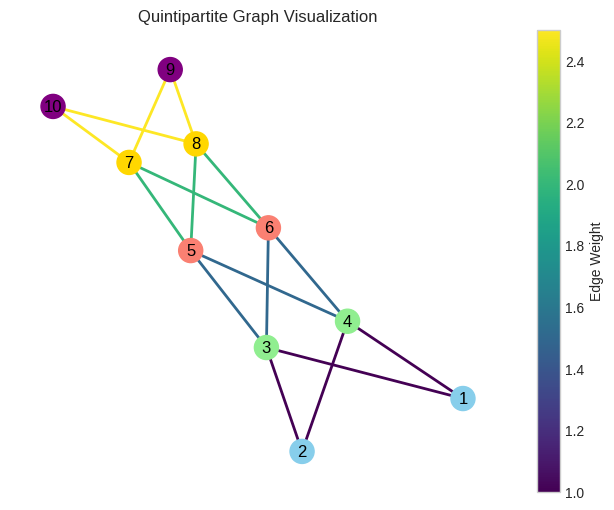

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Create a quintipartite graph
G = nx.Graph()

# Add nodes with a 'type' attribute to define the partitions
G.add_nodes_from([1, 2], type='a')
G.add_nodes_from([3, 4], type='b')
G.add_nodes_from([5, 6], type='c')
G.add_nodes_from([7, 8], type='d')
G.add_nodes_from([9, 10], type='e') # Add a fifth partition

# Add edges with different weights between partitions
w1 = 1
w2 = 1.5
w3 = 2
w4 = 2.5 # Add a new weight

# Edges between 'a' and 'b'
G.add_edge(1, 3, weight=w1)
G.add_edge(1, 4, weight=w1)
G.add_edge(2, 3, weight=w1)
G.add_edge(2, 4, weight=w1)

# Edges between 'b' and 'c'
G.add_edge(3, 5, weight=w2)
G.add_edge(3, 6, weight=w2)
G.add_edge(4, 5, weight=w2)
G.add_edge(4, 6, weight=w2)

# Edges between 'c' and 'd'
G.add_edge(5, 7, weight=w3)
G.add_edge(5, 8, weight=w3)
G.add_edge(6, 7, weight=w3)
G.add_edge(6, 8, weight=w3)

# Edges between 'd' and 'e' (new connections)
G.add_edge(7, 9, weight=w4)
G.add_edge(7, 10, weight=w4)
G.add_edge(8, 9, weight=w4)
G.add_edge(8, 10, weight=w4)

# Compute the distance matrix using the 'weight' attribute
# Use weight='weight' to consider edge weights
D = np.array(nx.floyd_warshall_numpy(G, weight='weight'))

print("Quintipartite Graph Distance Matrix D:\n", D)

# --- Visualize the graph ---
pos = nx.spring_layout(G) # Or other layout like bipartite_layout

# Define node colors based on partition
node_colors = []
for node in G.nodes():
    if G.nodes[node]['type'] == 'a':
        node_colors.append('skyblue')
    elif G.nodes[node]['type'] == 'b':
        node_colors.append('lightgreen')
    elif G.nodes[node]['type'] == 'c':
        node_colors.append('salmon')
    elif G.nodes[node]['type'] == 'd':
        node_colors.append('gold')
    elif G.nodes[node]['type'] == 'e': # Add color for the new partition
        node_colors.append('purple')

# Define edge colors based on weight
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]

fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.cm.viridis # Choose a colormap for edge weights
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors,
        width=2.0, edge_cmap=cmap, ax=ax)
plt.title("Quintipartite Graph Visualization")
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
sm.set_array([]) # Or a small array like np.array([])
cbar = fig.colorbar(sm, ax=ax, label='Edge Weight')
plt.show()

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def create_n_partite_graph(partition_sizes, edge_lengths_dict):
    """
    Creates an n-partite graph based on partition sizes and edge lengths between partitions.

    Args:
        partition_sizes (list): A list of integers representing the number of nodes in each partition.
        edge_lengths_dict (dict): A dictionary where keys are tuples of partition indices (i, j)
                                  and values are the lengths of edges between nodes in partition i and partition j.

    Returns:
        nx.Graph: The constructed n-partite graph.
    """
    G = nx.Graph()
    node_id = 1
    partition_nodes = []

    # Add nodes to each partition
    for i, size in enumerate(partition_sizes):
        nodes_in_partition = list(range(node_id, node_id + size))
        G.add_nodes_from(nodes_in_partition, type=f'p{i}')
        partition_nodes.append(nodes_in_partition)
        node_id += size

    # Add edges between partitions with specified lengths
    for (p1_idx, p2_idx), length in edge_lengths_dict.items():
        if p1_idx < len(partition_sizes) and p2_idx < len(partition_sizes) and p1_idx != p2_idx:
            for u in partition_nodes[p1_idx]:
                for v in partition_nodes[p2_idx]:
                    G.add_edge(u, v, length=length, weight=1/length)

    return G

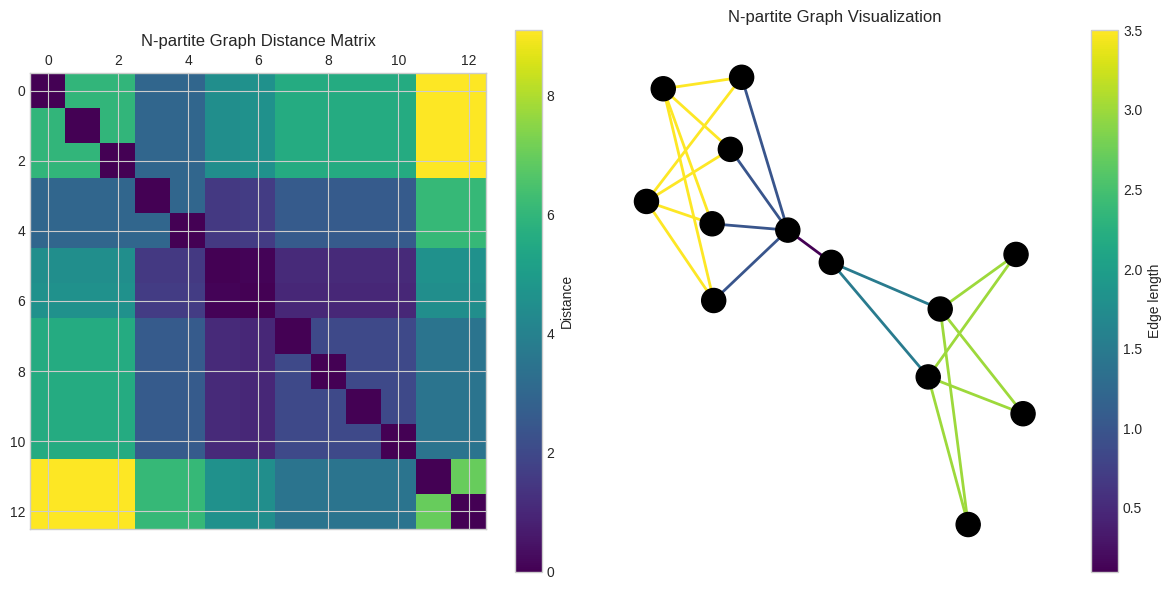

In [ ]:
# # --- Example Usage ---
# # Define partition sizes
# partitions = [2, 2, 2, 2, 2] # Example for a quintipartite graph with 2 nodes per partition

# # Define edge lengths between partitions (using 0-based indexing for partitions)
# lengths = {
# #     (0, 1): 1,
# #     (1, 2): 1.5,
# #     (2, 3): 2,
# #     (3, 4): 2.5
# # }

# --- Example Usage ---
# Define partition sizes
partitions = [3, 2, 3, 2, 3, 2] # Example for a quintipartite graph with 2 nodes per partition

# Define edge lengths between partitions (using 0-based indexing for partitions)
lengths = {
    (0, 1): 2.0,
    (1, 2): 3.0,
    (2, 3): 0.1,
    (3, 4): 1.5,
    (4, 5): 2.5
}

partitions = [3, 2, 1, 1, 4, 2] # Example for a quintipartite graph with 2 nodes per partition
lengths = {
    (0, 1): 3,
    (1, 2): 1.5,
    (2, 3): 0.1,
    (3, 4): 1.0,
    (4, 5): 3.5
}

# Create the n-partite graph
G = create_n_partite_graph(partitions, lengths)

# Compute the distance matrix
D = np.array(nx.floyd_warshall_numpy(G, weight='length'))

# --- Visualize the graph distance matrix and the graph in subplots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # 1 row, 2 columns
cmap = plt.cm.viridis # Choose a colormap for edge lengths

# Visualize the graph distance matrix (in the first subplot)
im = axes[0].matshow(D, cmap=cmap)
axes[0].set_title("N-partite Graph Distance Matrix")
fig.colorbar(im, ax=axes[0], label='Distance')

# Visualize the graph (in the second subplot)
# Use a layout that considers edge lengths
pos = nx.fruchterman_reingold_layout(G, weight='weight', k=0.5/np.sqrt(G.order()))

# Set all node colors to black
node_colors = ['black'] * len(G.nodes())

# Define edge colors based on length
edge_lengths_list = [G[u][v]['length'] for u, v in G.edges()]

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_lengths_list,
        width=2.0, edge_cmap=cmap, ax=axes[1]) # Draw on the second subplot
axes[1].set_title("N-partite Graph Visualization")
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=min(edge_lengths_list), vmax=max(edge_lengths_list)))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes[1], label='Edge length')

plt.tight_layout()
plt.show()

In [ ]:
A_func = lambda t: np.exp(-t * D)
dA_func = lambda t: -D * np.exp(-t * D)

In [ ]:
print("\nStarting n-partite graph eigen-decomposition tracking...")
t_start, t_end = 4.0, 1.0e-2
t_eval = np.geomspace(t_start, t_end, 10000)
Qs, Lambdas, sol = track_eigen_decomposition(
    A_func, dA_func, (t_start, t_end), t_eval, rtol=1e-13, atol=1e-12
)
print("Graph tracking finished successfully.")


Starting n-partite graph eigen-decomposition tracking...
Graph tracking finished successfully.


In [ ]:
# 1. Extract the eigenvalue traces from the Lambdas list
eigenvalues_traces = np.array([np.diag(L) for L in Lambdas])

# 2. Initialize a list to store the indices of eigenvalues crossing zero
zero_indices = []

# 3. Iterate through each eigenvalue trace and check if it crosses zero
for i in range(eigenvalues_traces.shape[1]):
    lambda_i = eigenvalues_traces[:, i]
    if np.amin(lambda_i) < 0.0 < np.amax(lambda_i):
        zero_indices.append(i)


In [ ]:
magnitudes = []
pseudo_magnitudes = []
errors = [] # Add a list to store the errors

for i, t in enumerate(sol.t): # Use sol.t for actual time points
    Q_t = Qs[i]
    Lambda_t = Lambdas[i]

    # Handle potential singular matrices or very small eigenvalues by using pinv
    Lambda_inverse = np.linalg.inv(Lambda_t)

    v = Q_t.T @ np.ones(D.shape[0])

    # Calculate magnitude
    mag = v.T @ Lambda_inverse @ v
    magnitudes.append(mag)

    # Calculate pseudo-magnitude
    pseudo_Lambda_inverse = Lambda_inverse.copy()
    # Set the diagonal elements corresponding to the zero_indices to zero
    if zero_indices: # Check if zero_indices is not empty
      pseudo_Lambda_inverse[zero_indices, zero_indices] = 0

    pseudo_mag = v.T @ pseudo_Lambda_inverse @ v
    pseudo_magnitudes.append(pseudo_mag)

    # Calculate reconstruction error
    A_t = A_func(t)
    reconstructed_A = Q_t @ Lambda_t @ Q_t.T
    error = np.linalg.norm(A_t - reconstructed_A, 'fro')
    errors.append(error)

print("Magnitudes, pseudo-magnitudes, and reconstruction errors for graph calculated.")

Magnitudes, pseudo-magnitudes, and reconstruction errors for graph calculated.


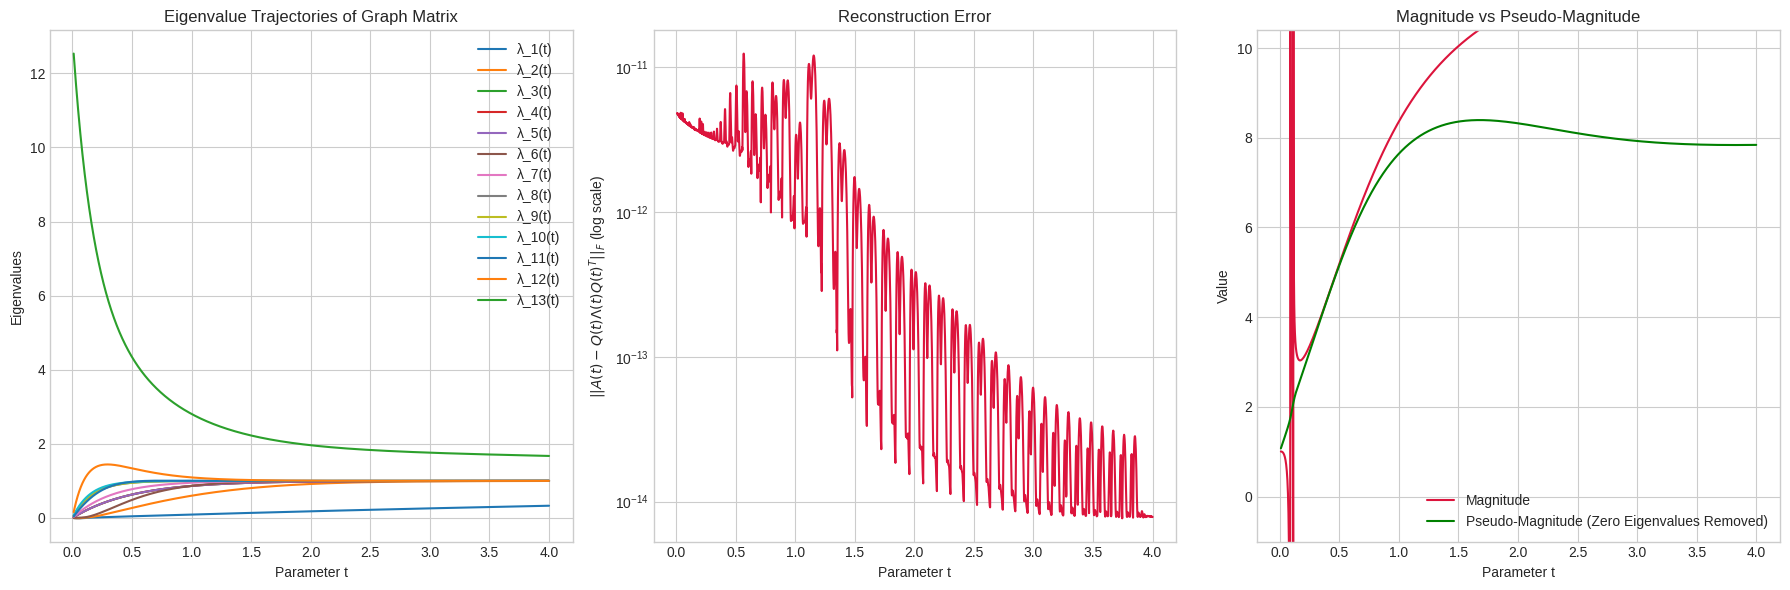


Final magnitude at t=0.0100: 1.0070
Final pseudo-magnitude at t=0.0100: 1.0781
zero_indices=[0, 1]


In [ ]:
# --- プロット ---
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(18, 6)) # Adjusted figure size for better visibility

# 固有値の軌跡をプロット
ax1 = fig.add_subplot(1, 3, 1)
for i in range(eigenvalues_traces.shape[1]):
    ax1.plot(sol.t, eigenvalues_traces[:, i], label=f'λ_{i+1}(t)')
ax1.set_title('Eigenvalue Trajectories of Graph Matrix')
ax1.set_xlabel('Parameter t')
ax1.set_ylabel('Eigenvalues')
ax1.legend()
ax1.grid(True)

# Reconstruction Errorをプロット
ax2 = fig.add_subplot(1, 3, 2)
ax2.semilogy(sol.t, errors, color='crimson') # Plot errors on a log scale
ax2.set_title('Reconstruction Error')
ax2.set_xlabel('Parameter t')
ax2.set_ylabel(r'$||A(t) - Q(t)\Lambda(t)Q(t)^T||_F$ (log scale)')
ax2.grid(True)

# マグニチュードと擬似マグニチュードをプロット
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(sol.t, magnitudes, color='crimson', label='Magnitude')
ax3.plot(sol.t, pseudo_magnitudes, color='green', label='Pseudo-Magnitude (Zero Eigenvalues Removed)')
ax3.set_title('Magnitude vs Pseudo-Magnitude')
ax3.set_xlabel('Parameter t')
ax3.set_ylabel('Value')
# Set a reasonable y-axis limit, avoiding negative values if magnitudes are non-negative
y_min = -1
y_max = max(pseudo_magnitudes) + 2
ax3.set_ylim(y_min, y_max)

ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal magnitude at t={sol.t[-1]:.4f}: {magnitudes[-1]:.4f}")
print(f"Final pseudo-magnitude at t={sol.t[-1]:.4f}: {pseudo_magnitudes[-1]:.4f}")
print(f"{zero_indices=}")

In [ ]:
from scipy.optimize import linear_sum_assignment
from scipy.linalg import eigh

def match_decompositions(predicted_eigvals, predicted_eigvecs,
                         exact_eigvals, exact_eigvecs):
    """
    正確な対角化分解を、予測された対角化分解にマッチさせる。

    この関数は、ハンガリー法を用いて固有値の最適な対応付け（並べ替え）を
    見つけ出し、その後、対応する固有ベクトル間の内積を計算して符号を揃える。
    これにより、`eigh`のような関数の出力順序や符号の任意性に起因する不連続性を
    解消し、時間積分の連続性を維持する。

    Args:
        predicted_eigvals (np.ndarray): 1D配列。予測された固有値。
        predicted_eigvecs (np.ndarray): 2D配列。予測された固有ベクトル（列ベクトル）。
        exact_eigvals (np.ndarray): 1D配列。正確に計算された固有値。
        exact_eigvecs (np.ndarray): 2D配列。正確に計算された固有ベクトル（列ベクトル）。

    Returns:
        tuple[np.ndarray, np.ndarray]:
            - matched_eigvals: `predicted_eigvals` の順序に並べ替えられた `exact_eigvals`。
            - matched_eigvecs: `predicted_eigvecs` の順序と符号に合わせられた `exact_eigvecs`。
    """
    # --- ステップ1: 固有値の最適な対応付け（並べ替え）を見つける ---
    # コスト行列を計算する。C[i, j]は i 番目の予測値と j 番目の正確な値の差。
    # このコストを最小化するようなペアリングを見つけることが目的。
    cost_matrix = np.abs(predicted_eigvals[:, np.newaxis] - exact_eigvals[np.newaxis, :])

    # ハンガリー法（線形和割り当て問題）を解き、最適なペアリングを見つける
    # pred_indices[i] は、exact_indices[i] に対応する
    pred_indices, exact_indices = linear_sum_assignment(cost_matrix)

    # 並べ替えられた正確な値を格納する配列を準備
    matched_eigvals = np.zeros_like(exact_eigvals)
    matched_eigvecs = np.zeros_like(exact_eigvecs)

    # 見つかった対応付けに従って、正確な値を並べ替える
    # pred_indices は通常 0, 1, 2, ... となるので、exact_indices が置換を表す
    matched_eigvals = exact_eigvals[exact_indices]
    matched_eigvecs = exact_eigvecs[:, exact_indices]

    # --- ステップ2: 対応する固有ベクトルの符号を合わせる ---
    # 各々の対応するベクトル対の内積を計算する
    # 内積が負の場合、ベクトルは反対方向を向いているため、一方の符号を反転させる
    for i in range(predicted_eigvecs.shape[1]):
        dot_product = np.dot(predicted_eigvecs[:, i], matched_eigvecs[:, i])
        if dot_product < 0.0:
            matched_eigvecs[:, i] *= -1.0

    return matched_eigvals, matched_eigvecs

In [ ]:
n = 4
np.random.seed(0)

# 1. 基準となる「予測」対角化分解を生成
A_pred = np.random.rand(n, n)
A_pred = A_pred + A_pred.T # 対称化
predicted_eigvals, predicted_eigvecs = eigh(A_pred)

print("--- 入力データ ---")
print("予測された固有値:\n", predicted_eigvals)

# 2. 順序がシャッフルされ、符号がランダムに反転した「正確な」分解を生成
# これが `eigh` から返される、順序や符号が不定な状態を模倣する
shuffle_permutation = np.random.permutation(n)
exact_eigvals_shuffled = predicted_eigvals[shuffle_permutation]
exact_eigvecs_shuffled = predicted_eigvecs[:, shuffle_permutation]

random_signs = np.random.choice([-1.0, 1.0], n)
exact_eigvecs_flipped = exact_eigvecs_shuffled * random_signs

print("\nシャッフル＆反転された（マッチング前の）正確な固有値:\n", exact_eigvals_shuffled)

# 3. マッチング関数を実行
print("\n--- マッチング実行 ---")
matched_vals, matched_vecs = match_decompositions(
    predicted_eigvals,
    predicted_eigvecs,
    exact_eigvals_shuffled, # 順序がバラバラ
    exact_eigvecs_flipped   # 符号もバラバラ
)

# 4. 結果を検証
print("\nマッチング後の固有値:\n", matched_vals)
print("\n元の予測固有値との差 (ほぼゼロのはず):")
print(matched_vals - predicted_eigvals)

print("\nマッチング後の固有ベクトルと元の予測固有ベクトルの差のノルム (ほぼゼロのはず):")
print(np.linalg.norm(matched_vecs - predicted_eigvecs))

# NumPyのテスト関数で厳密に検証
try:
    np.testing.assert_allclose(predicted_eigvals, matched_vals, atol=1e-9)
    np.testing.assert_allclose(predicted_eigvecs, matched_vecs, atol=1e-9)
    print("\n✅ 検証成功: 固有値・固有ベクトルが元の順序と符号に正しく復元されました。")
except AssertionError as e:
    print("\n❌ 検証失敗:")
    print(e)

--- 入力データ ---
予測された固有値:
 [-1.21115868 -0.34561291  1.08987198  4.61402353]

シャッフル＆反転された（マッチング前の）正確な固有値:
 [ 1.08987198 -0.34561291 -1.21115868  4.61402353]

--- マッチング実行 ---

マッチング後の固有値:
 [-1.21115868 -0.34561291  1.08987198  4.61402353]

元の予測固有値との差 (ほぼゼロのはず):
[0. 0. 0. 0.]

マッチング後の固有ベクトルと元の予測固有ベクトルの差のノルム (ほぼゼロのはず):
0.0

✅ 検証成功: 固有値・固有ベクトルが元の順序と符号に正しく復元されました。


--- 事後補正のテスト ---

Max error before correction: 1.24e-11
Max error after correction:  3.11e-13


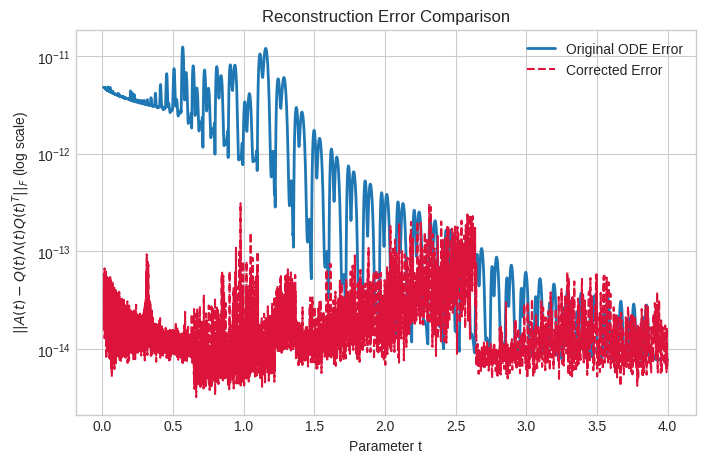

In [ ]:
from scipy.optimize import linear_sum_assignment
from scipy.linalg import eigh
import numpy as np

def correct_trajectory(A_func, t_eval, Qs_ode, Lambdas_ode):
    """
    ODEソルバーで追跡した固有値分解を、各時刻で正確に計算した分解に事後補正する。
    ODE結果をガイドとして、正確な分解を並べ替え・符号合わせする。

    Args:
        A_func (callable): 時刻 t を受け取り、真の行列 A(t) を返す関数。
        t_eval (np.ndarray): 評価時刻の1D配列。
        Qs_ode (list of np.ndarray): ODEソルバーから得られた固有ベクトル行列のリスト。
        Lambdas_ode (list of np.ndarray): ODEソルバーから得られた対角固有値行列のリスト。

    Returns:
        tuple[list[np.ndarray], list[np.ndarray]]:
            - corrected_Qs: 補正された固有ベクトル行列のリスト。
            - corrected_Lambdas: 補正された対角固有値行列のリスト。
    """
    corrected_Qs = []
    corrected_Lambdas = []

    for i, t in enumerate(t_eval):
        # 1. その時刻における真の行列 A_t を計算
        A_t = A_func(t)

        # 2. A_t の正確な固有値分解を計算
        exact_eigvals, exact_eigvecs = eigh(A_t)

        # 3. match_decompositions を用いて、正確な分解をODE結果にマッチさせる
        # ODE結果を「予測」、正確な計算を「正確」として渡す
        # Lambdas_ode は対角行列なので、固有値を取り出す
        predicted_eigvals = np.diag(Lambdas_ode[i])
        predicted_eigvecs = Qs_ode[i]

        matched_eigvals, matched_eigvecs = match_decompositions(
            predicted_eigvals,
            predicted_eigvecs,
            exact_eigvals,
            exact_eigvecs
        )

        # 4. 補正結果をリストに追加
        corrected_Qs.append(matched_eigvecs)
        corrected_Lambdas.append(np.diag(matched_eigvals)) # 対角行列に戻す

    return corrected_Qs, corrected_Lambdas

# --- テストコード例 ---
# (前のセルで track_eigen_decomposition を実行し、
#  変数 A_func, sol, Qs, Lambdas, errors が定義済みであると仮定します)

print("--- 事後補正のテスト ---")

# 新しい関数を呼び出して事後補正を実行
corrected_Qs, corrected_Lambdas = correct_trajectory(
    A_func,
    sol.t, # 実際に評価された時刻
    Qs,
    Lambdas
)

# 補正後の再構成誤差を計算
corrected_errors = []
for i, t in enumerate(sol.t):
    A_t = A_func(t)
    reconstructed_A = corrected_Qs[i] @ corrected_Lambdas[i] @ corrected_Qs[i].T
    error = np.linalg.norm(A_t - reconstructed_A, 'fro')
    corrected_errors.append(error)

# 補正後の誤差がほぼゼロであることを確認
print(f"\nMax error before correction: {np.max(errors):.2e}")
print(f"Max error after correction:  {np.max(corrected_errors):.2e}")

# プロット用の変数名を更新 (もしプロットを続ける場合)
errors_before_correction = errors
errors_after_correction = corrected_errors

# 元の誤差と補正後の誤差を比較するプロット
plt.figure(figsize=(8, 5))
plt.semilogy(sol.t, errors, label='Original ODE Error', linewidth=2)
plt.semilogy(sol.t, corrected_errors, label='Corrected Error', linestyle='--', color='crimson')
plt.title('Reconstruction Error Comparison')
plt.xlabel('Parameter t')
plt.ylabel(r'$||A(t) - Q(t)\Lambda(t)Q(t)^T||_F$ (log scale)')
plt.legend()
plt.grid(True)
plt.show()

Magnitudes and pseudo-magnitudes computed using corrected data.


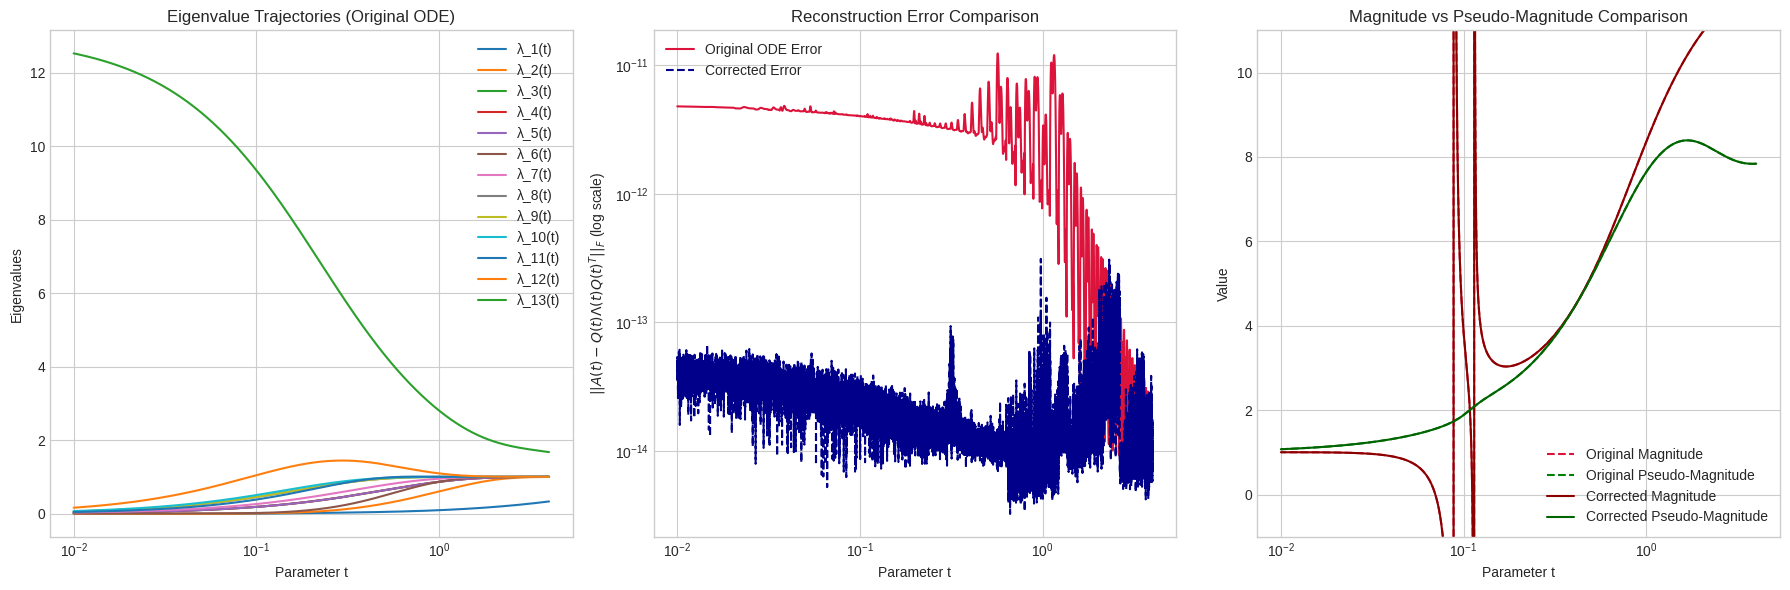


Final corrected magnitude at t=0.0100: 1.0070
Final corrected pseudo-magnitude at t=0.0100: 1.0781


In [ ]:
# Recompute magnitudes and pseudo-magnitudes using corrected data
corrected_magnitudes = []
corrected_pseudo_magnitudes = []

for i, t in enumerate(sol.t):
    Q_t = corrected_Qs[i]
    Lambda_t = corrected_Lambdas[i]

    # Handle potential singular matrices or very small eigenvalues by using pinv
    Lambda_inverse = np.linalg.pinv(Lambda_t)

    v = Q_t.T @ np.ones(D.shape[0])

    # Calculate magnitude
    mag = v.T @ Lambda_inverse @ v
    corrected_magnitudes.append(mag)

    # Calculate pseudo-magnitude
    pseudo_Lambda_inverse = Lambda_inverse.copy()
    # Set the diagonal elements corresponding to the zero_indices to zero
    if zero_indices:
      pseudo_Lambda_inverse[zero_indices, zero_indices] = 0

    pseudo_mag = v.T @ pseudo_Lambda_inverse @ v
    corrected_pseudo_magnitudes.append(pseudo_mag)

print("Magnitudes and pseudo-magnitudes computed using corrected data.")

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(18, 6))

# Eigenvalue Trajectories (using original for comparison)
ax1 = fig.add_subplot(1, 3, 1)
for i in range(eigenvalues_traces.shape[1]):
    ax1.plot(sol.t, eigenvalues_traces[:, i], label=f'λ_{i+1}(t)')
ax1.set_title('Eigenvalue Trajectories (Original ODE)')
ax1.set_xlabel('Parameter t')
ax1.set_xscale('log')
ax1.set_ylabel('Eigenvalues')
ax1.legend()
ax1.grid(True)

# Reconstruction Error (comparing original and corrected)
ax2 = fig.add_subplot(1, 3, 2)
ax2.semilogy(sol.t, errors_before_correction, label='Original ODE Error', color='crimson')
ax2.semilogy(sol.t, errors_after_correction, label='Corrected Error', linestyle='--', color='darkblue')
ax2.set_title('Reconstruction Error Comparison')
ax2.set_xscale('log')
ax2.set_xlabel('Parameter t')
ax2.set_ylabel(r'$||A(t) - Q(t)\Lambda(t)Q(t)^T||_F$ (log scale)')
ax2.legend()
ax2.grid(True)


# Magnitudes vs Pseudo-Magnitudes (comparing original and corrected)
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(sol.t, magnitudes, color='crimson', linestyle='--', label='Original Magnitude')
ax3.plot(sol.t, pseudo_magnitudes, color='green', linestyle='--', label='Original Pseudo-Magnitude')
ax3.plot(sol.t, corrected_magnitudes, color='darkred', label='Corrected Magnitude')
ax3.plot(sol.t, corrected_pseudo_magnitudes, color='darkgreen', label='Corrected Pseudo-Magnitude')

ax3.set_title('Magnitude vs Pseudo-Magnitude Comparison')
ax3.set_xscale('log')
ax3.set_xlabel('Parameter t')
ax3.set_ylabel('Value')
# Set a reasonable y-axis limit, avoiding negative values if magnitudes are non-negative
ax3.set_ylim(-1, np.ceil(max(pseudo_magnitudes)) + 2)
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal corrected magnitude at t={sol.t[-1]:.4f}: {corrected_magnitudes[-1]:.4f}")
print(f"Final corrected pseudo-magnitude at t={sol.t[-1]:.4f}: {corrected_pseudo_magnitudes[-1]:.4f}")

# Task
Refactor the code by creating a calculation function that takes a NetworkX graph as input and returns a namedtuple containing all computed results (ODE solution, eigenvalues, eigenvectors, magnitudes, errors, corrected values, etc.), and a visualization function that takes the namedtuple and plots the results (eigenvalue trajectories, reconstruction errors, magnitudes).

## Define namedtuple

### Subtask:
Define a `namedtuple` to hold all the results from the calculation function (e.g., `sol`, `Qs`, `Lambdas`, `eigenvalues_traces`, `zero_indices`, `magnitudes`, `pseudo_magnitudes`, `errors`, `corrected_Qs`, `corrected_Lambdas`, `corrected_magnitudes`, `corrected_pseudo_magnitudes`, `errors_before_correction`, `errors_after_correction`).


**Reasoning**:
Define a namedtuple to store the results of the eigen-decomposition tracking.



# Task
Refactor the eigenvalue tracking and analysis code into two functions: one for computation (`track_and_analyze_eigenvalue_decomposition`) and one for visualization (`plot_eigen_tracking_results`). The computation function should take a NetworkX graph and an optional `apply_correction` flag, returning a `namedtuple` (`EigenTrackingResults`) containing the results (time points, Qs, Lambdas, magnitudes, pseudo_magnitudes, errors, zero_indices, success, message, state, and optionally errors_before_correction if correction is applied) with simplified key names. The visualization function should take the `EigenTrackingResults` namedtuple and an optional axes object, plotting the results and returning the axes. Update the example usage to use these new functions.

## Define namedtuple

### Subtask:
Define a `namedtuple` to hold all the results from the calculation function (e.g., `sol`, `Qs`, `Lambdas`, `eigenvalues_traces`, `zero_indices`, `magnitudes`, `pseudo_magnitudes`, `errors`, `corrected_Qs`, `corrected_Lambdas`, `corrected_magnitudes`, `corrected_pseudo_magnitudes`, `errors_before_correction`, `errors_after_correction`).


**Reasoning**:
Define a namedtuple to store the results of the eigen-decomposition tracking.



In [ ]:
from collections import namedtuple

# Define the namedtuple structure
EigenTrackingResults = namedtuple(
    'EigenTrackingResults',
    [
        't_eval',
        'Qs',
        'Lambdas',
        'magnitudes',
        'pseudo_magnitudes',
        'errors',
        'zero_indices',
        'success',
        'message',
        'state',
        'errors_before_correction' # This will be None if correction is not applied
    ]
)

## Create calculation function

### Subtask:
Implement a function `track_and_analyze_eigenvalue_decomposition` that performs the eigenvalue tracking and analysis, returning an `EigenTrackingResults` namedtuple.


**Reasoning**:
Implement the `track_and_analyze_eigenvalue_decomposition` function to perform the eigenvalue tracking and analysis, returning the results in an `EigenTrackingResults` namedtuple as specified in the instructions.



In [ ]:
from collections import namedtuple

# Define the namedtuple structure (re-defining here for completeness of the function block)
# This definition should ideally be done once at the top level.
# Assuming it's already defined in a previous cell.
# EigenTrackingResults = namedtuple(
#     'EigenTrackingResults',
#     [
#         't_eval',
#         'Qs',
#         'Lambdas',
#         'magnitudes',
#         'pseudo_magnitudes',
#         'errors',
#         'zero_indices',
#         'success',
#         'message',
#         'state',
#         'errors_before_correction' # This will be None if correction is not applied
#     ]
# )


def track_and_analyze_eigenvalue_decomposition(G, apply_correction=True):
    """
    Performs eigenvalue tracking and analysis for a graph's distance matrix
    exponentiated, returning results in a namedtuple.

    Args:
        G (nx.Graph): The input NetworkX graph.
        apply_correction (bool): Whether to apply post-hoc correction using
                                 exact diagonalization at each time step.

    Returns:
        EigenTrackingResults: A namedtuple containing the results.
    """
    # 1. Compute the distance matrix D from the input graph G
    try:
        D = np.array(nx.floyd_warshall_numpy(G, weight='length'))
    except nx.NetworkXNoPath:
         # Handle disconnected graphs if necessary, or let it propagate
         return EigenTrackingResults(
            t_eval=None, Qs=None, Lambdas=None, magnitudes=None,
            pseudo_magnitudes=None, errors=None, zero_indices=None,
            success=False, message="Graph is disconnected.", state=None,
            errors_before_correction=None
        )


    # 2. Define the matrix functions A(t) and dA/dt
    A_func = lambda t: np.exp(-t * D)
    dA_func = lambda t: -D * np.exp(-t * D)

    # 3. Define time span and evaluation points
    t_start, t_end = 4.0, 1.0e-2 # Example time span
    t_eval = np.geomspace(t_start, t_end, 10000)

    # 4. Call the track_eigen_decomposition function
    Qs_ode, Lambdas_ode, sol = None, None, None
    success = False
    message = "Tracking failed."
    state = None

    try:
        Qs_ode, Lambdas_ode, sol = track_eigen_decomposition(
            A_func, dA_func, (t_start, t_end), t_eval, rtol=1e-13, atol=1e-12
        )
        success = sol.success
        message = sol.message
        state = sol.status
    except RuntimeError as e:
        message = f"Tracking failed: {e}"

    # If tracking failed, return early
    if not success:
         return EigenTrackingResults(
            t_eval=sol.t if sol else None, Qs=None, Lambdas=None, magnitudes=None,
            pseudo_magnitudes=None, errors=None, zero_indices=None,
            success=success, message=message, state=state,
            errors_before_correction=None
        )


    # 6. Extract the original eigenvalue traces
    eigenvalues_traces = np.array([np.diag(L) for L in Lambdas_ode])

    # 7. Identify indices of eigenvalues that cross zero
    zero_indices = []
    for i in range(eigenvalues_traces.shape[1]):
        lambda_i = eigenvalues_traces[:, i]
        if np.amin(lambda_i) < 0.0 < np.amax(lambda_i):
            zero_indices.append(i)

    # 8. Calculate original magnitudes, pseudo-magnitudes, and reconstruction errors
    original_magnitudes = []
    original_pseudo_magnitudes = []
    errors_before_correction = []

    for i, t in enumerate(sol.t):
        Q_t = Qs_ode[i]
        Lambda_t = Lambdas_ode[i]

        Lambda_inverse = np.linalg.inv(Lambda_t)

        v = Q_t.T @ np.ones(D.shape[0])

        mag = v.T @ Lambda_inverse @ v
        original_magnitudes.append(mag)

        pseudo_Lambda_inverse = Lambda_inverse.copy()
        if zero_indices:
            pseudo_Lambda_inverse[zero_indices, zero_indices] = 0

        pseudo_mag = v.T @ pseudo_Lambda_inverse @ v
        original_pseudo_magnitudes.append(pseudo_mag)

        A_t = A_func(t)
        reconstructed_A = Q_t @ Lambda_t @ Q_t.T
        error = np.linalg.norm(A_t - reconstructed_A, 'fro')
        errors_before_correction.append(error)

    # 9. Initialize variables for corrected results
    corrected_Qs = None
    corrected_Lambdas = None
    corrected_magnitudes = None
    corrected_pseudo_magnitudes = None
    errors_after_correction = None

    # 10. Apply correction if requested
    if apply_correction:
        try:
            corrected_Qs, corrected_Lambdas = correct_trajectory(
                A_func, sol.t, Qs_ode, Lambdas_ode
            )

            # Calculate corrected magnitudes and pseudo-magnitudes
            corrected_magnitudes = []
            corrected_pseudo_magnitudes = []
            errors_after_correction = []

            for i, t in enumerate(sol.t):
                Q_t = corrected_Qs[i]
                Lambda_t = corrected_Lambdas[i]

                Lambda_inverse = np.linalg.inv(Lambda_t)

                v = Q_t.T @ np.ones(D.shape[0])

                mag = v.T @ Lambda_inverse @ v
                corrected_magnitudes.append(mag)

                pseudo_Lambda_inverse = Lambda_inverse.copy()
                if zero_indices:
                    pseudo_Lambda_inverse[zero_indices, zero_indices] = 0

                pseudo_mag = v.T @ pseudo_Lambda_inverse @ v
                corrected_pseudo_magnitudes.append(pseudo_mag)

                # Calculate corrected reconstruction error
                A_t = A_func(t)
                reconstructed_A = Q_t @ Lambda_t @ Q_t.T
                error = np.linalg.norm(A_t - reconstructed_A, 'fro')
                errors_after_correction.append(error)

        except Exception as e:
            print(f"Correction failed: {e}")
            # Proceed with original results if correction fails
            apply_correction = False # Revert to original results


    # 11. Select results based on apply_correction flag
    if apply_correction:
        final_Qs = corrected_Qs
        final_Lambdas = corrected_Lambdas
        final_magnitudes = corrected_magnitudes
        final_pseudo_magnitudes = corrected_pseudo_magnitudes
        final_errors = errors_after_correction
        final_errors_before_correction = errors_before_correction
    else:
        final_Qs = Qs_ode
        final_Lambdas = Lambdas_ode
        final_magnitudes = original_magnitudes
        final_pseudo_magnitudes = original_pseudo_magnitudes
        final_errors = errors_before_correction
        final_errors_before_correction = None # Set to None if correction wasn't applied


    # 12. Populate the EigenTrackingResults namedtuple
    results = EigenTrackingResults(
        t_eval=sol.t,
        Qs=final_Qs,
        Lambdas=final_Lambdas,
        magnitudes=final_magnitudes,
        pseudo_magnitudes=final_pseudo_magnitudes,
        errors=final_errors,
        zero_indices=zero_indices,
        success=success,
        message=message,
        state=state,
        errors_before_correction=final_errors_before_correction # Include only if correction applied
    )

    # 13. Return the namedtuple
    return results


## Create visualization function

### Subtask:
Implement a function, `plot_eigen_tracking_results`, that takes the `EigenTrackingResults` namedtuple and an optional `axes` object, plotting the eigenvalue trajectories, reconstruction errors, and magnitudes.


**Reasoning**:
Implement the `plot_eigen_tracking_results` function to visualize the results stored in the `EigenTrackingResults` namedtuple, creating subplots for eigenvalue trajectories, reconstruction errors, and magnitudes.



In [ ]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.linalg
import scipy.integrate

# Assume EigenTrackingResults namedtuple is already defined
# from collections import namedtuple
# EigenTrackingResults = namedtuple(...)

def plot_eigen_tracking_results(results: EigenTrackingResults, axes=None):
    """
    Plots the results from the EigenTrackingResults namedtuple.

    Args:
        results (EigenTrackingResults): The namedtuple containing the tracking results.
        axes (np.ndarray, optional): A numpy array of matplotlib axes objects
                                     (e.g., from plt.subplots(1, 3)).
                                     If None, a new figure and axes are created.

    Returns:
        np.ndarray: A numpy array of the used axes objects.
    """
    if axes is None:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        show_plot = True
    else:
        fig = axes[0].get_figure() # Get the figure from the provided axes
        show_plot = False

    # 1. Plot Eigenvalue Trajectories
    ax1 = axes[0]
    if results.Lambdas is not None and results.t_eval is not None:
        eigenvalues_traces = np.array([np.diag(L) for L in results.Lambdas])
        for i in range(eigenvalues_traces.shape[1]):
            ax1.plot(results.t_eval, eigenvalues_traces[:, i], label=f'λ_{i+1}(t)')
        ax1.set_title('Eigenvalue Trajectories')
        ax1.set_xlabel('Parameter t')
        ax1.set_xscale('log')
        ax1.set_ylabel('Eigenvalues')
        ax1.legend()
        ax1.grid(True)

    # 2. Plot Reconstruction Error
    ax2 = axes[1]
    if results.errors is not None and results.t_eval is not None:
        ax2.semilogy(results.t_eval, results.errors, label='Reconstruction Error', color='crimson')
        if results.errors_before_correction is not None:
             ax2.semilogy(results.t_eval, results.errors_before_correction, label='Original ODE Error', linestyle='--', color='darkblue')

        ax2.set_title('Reconstruction Error')
        ax2.set_xlabel('Parameter t')
        ax2.set_xscale('log')
        ax2.set_ylabel(r'$||A(t) - Q(t)\Lambda(t)Q(t)^T||_F$ (log scale)')
        ax2.legend()
        ax2.grid(True)


    # 3. Plot Magnitude vs Pseudo-Magnitude
    ax3 = axes[2]
    if results.magnitudes is not None and results.pseudo_magnitudes is not None and results.t_eval is not None:
        ax3.plot(results.t_eval, results.magnitudes, color='darkred', label='Magnitude')
        ax3.plot(results.t_eval, results.pseudo_magnitudes, color='darkgreen', label='Pseudo-Magnitude')

        ax3.set_title('Magnitude vs Pseudo-Magnitude')
        ax3.set_xlabel('Parameter t')
        ax3.set_xscale('log')
        ax3.set_ylabel('Value')
        # Set a reasonable y-axis limit
        y_min = -1
        y_max = np.amax(results.pseudo_magnitudes) + 2
        ax3.set_ylim(y_min, y_max)

        ax3.legend()
        ax3.grid(True)

    plt.tight_layout()

    if show_plot:
        plt.show()

    return axes

# Example Usage (assuming a graph G is already defined from previous cells)
# Assuming G is the n-partite graph created earlier
# Example results from track_and_analyze_eigenvalue_decomposition
# G_test = create_n_partite_graph([3, 2, 1, 1, 4, 2], {(0, 1): 3, (1, 2): 1.5, (2, 3): 0.1, (3, 4): 1.0, (4, 5): 3.5})
# results_example = track_and_analyze_eigenvalue_decomposition(G_test, apply_correction=True)

# Plotting the example results
# if results_example.success:
#     plot_eigen_tracking_results(results_example)

# Example of plotting on existing axes
# fig, axes_existing = plt.subplots(1, 3, figsize=(18, 6))
# if results_example.success:
#      plot_eigen_tracking_results(results_example, axes=axes_existing)
#      plt.suptitle("Plotting on Existing Axes Example") # Add a figure title
#      plt.show()


## Update example usage

### Subtask:
Modify the existing example usage in the notebook to call the new `track_and_analyze_eigenvalue_decomposition` and `plot_eigen_tracking_results` functions. Demonstrate both cases: with and without correction.


**Reasoning**:
Modify the existing code cell to call the new functions and demonstrate tracking with and without correction.



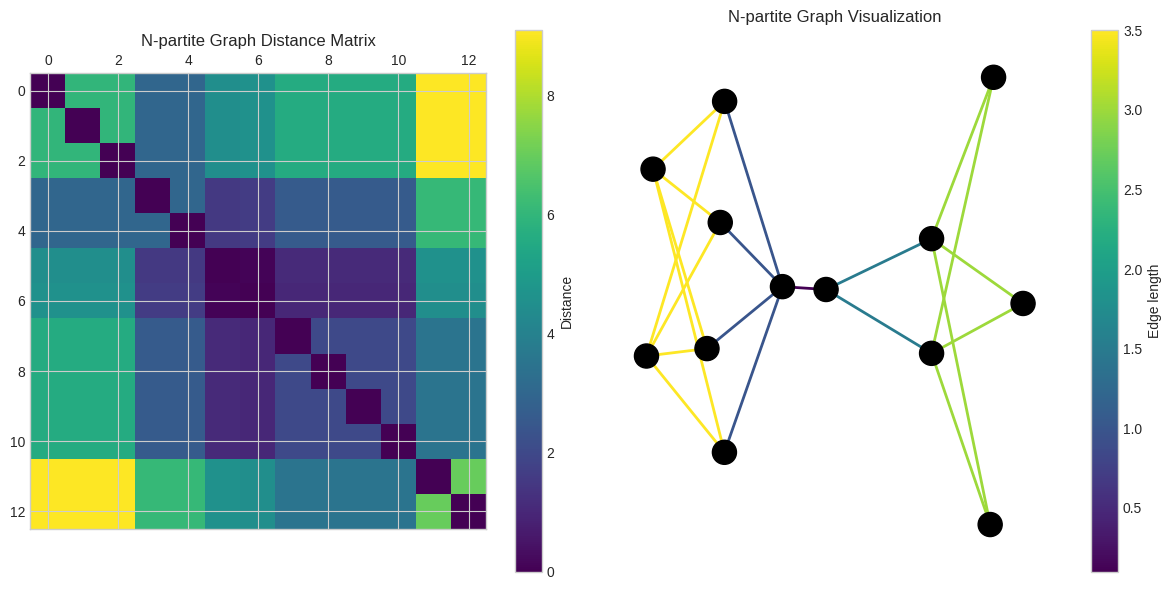


--- Starting tracking and analysis WITH correction ---
Tracking and analysis with correction finished successfully.
Plotting results with correction...


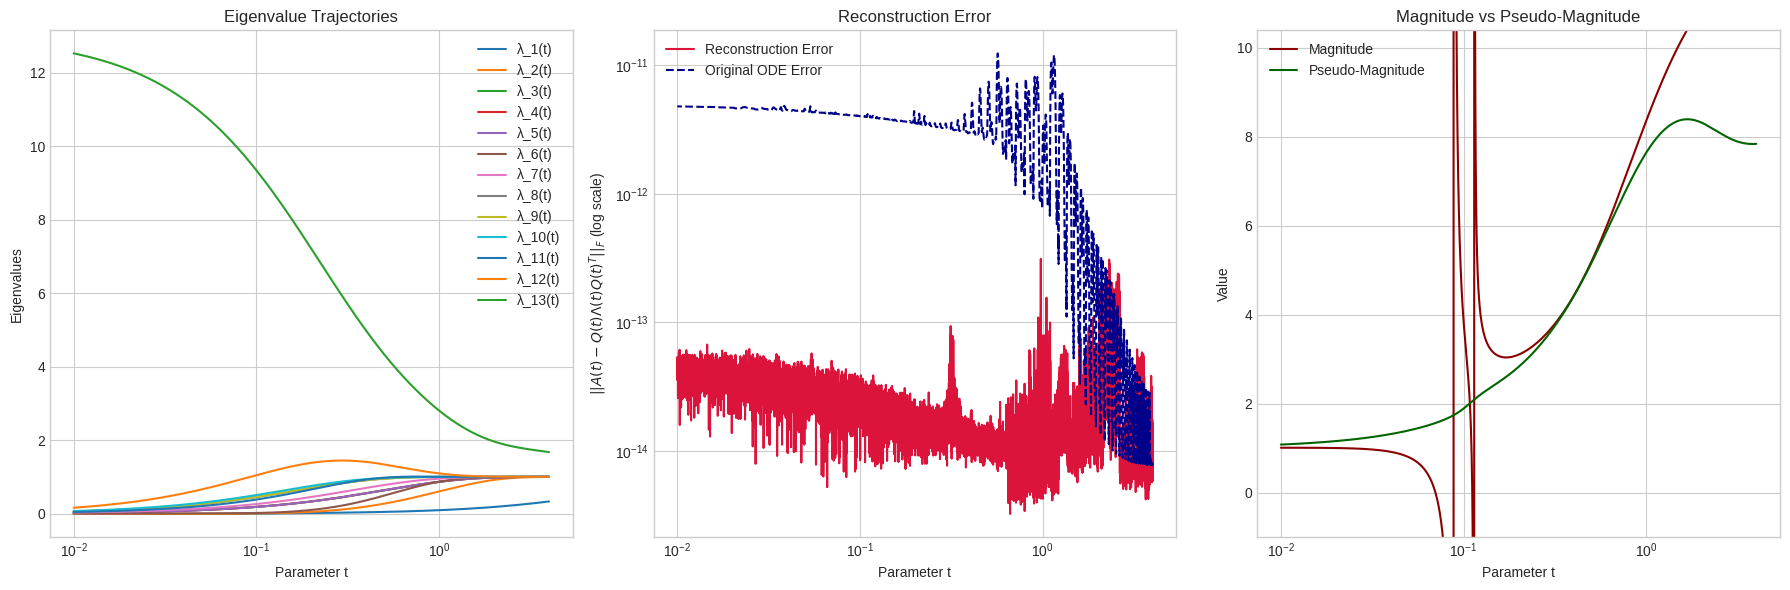


--- Starting tracking and analysis WITHOUT correction ---
Tracking and analysis without correction finished successfully.
Plotting results without correction...


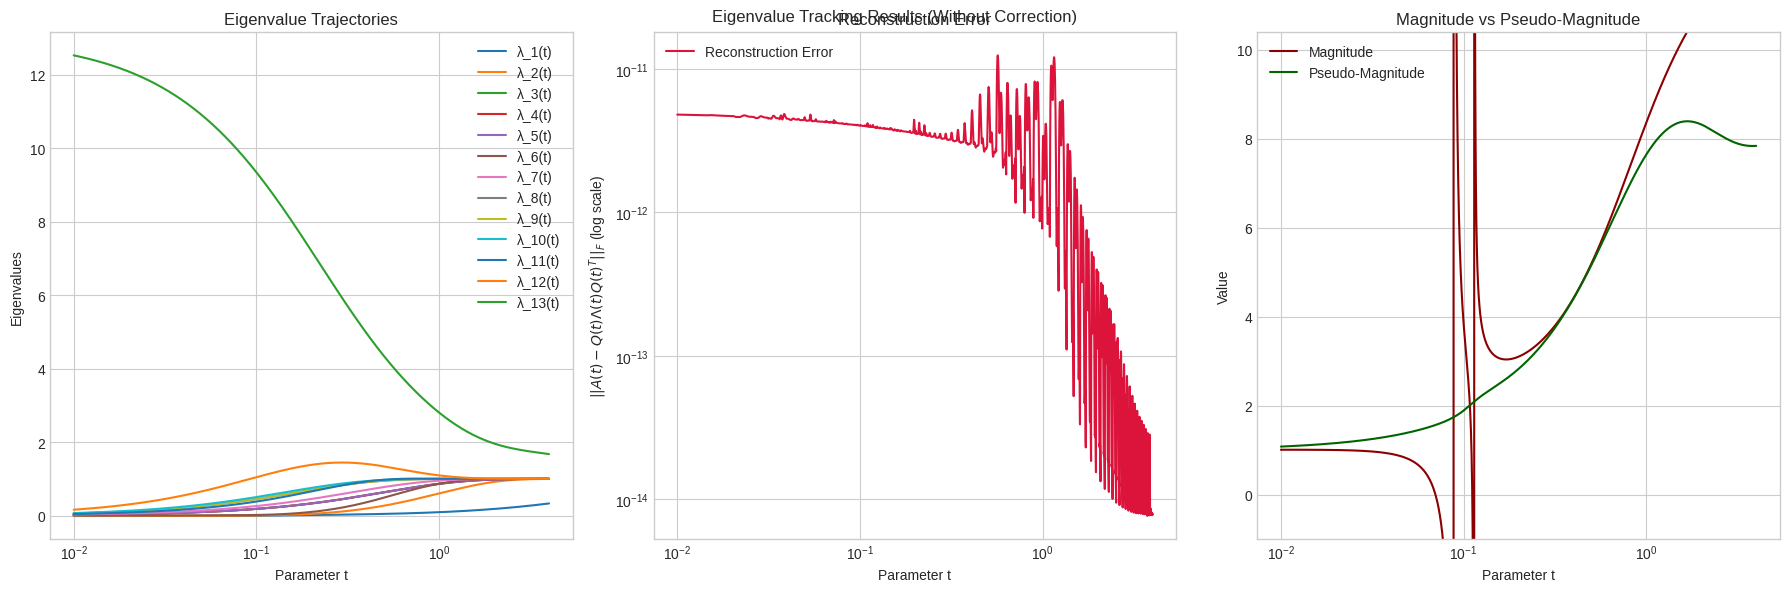

In [ ]:
# --- Example Usage ---
# Define partition sizes
partitions = [3, 2, 1, 1, 4, 2] # Example for a quintipartite graph with 2 nodes per partition
lengths = {
    (0, 1): 3,
    (1, 2): 1.5,
    (2, 3): 0.1,
    (3, 4): 1.0,
    (4, 5): 3.5
}

# Create the n-partite graph
G = create_n_partite_graph(partitions, lengths)

# Compute the distance matrix (still needed for A_func etc. within the function)
# D is also used for plotting the distance matrix initially, so keep this part
D = np.array(nx.floyd_warshall_numpy(G, weight='length'))

# --- Visualize the graph distance matrix and the graph initially ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # 1 row, 2 columns
cmap = plt.cm.viridis # Choose a colormap for edge lengths

# Visualize the graph distance matrix (in the first subplot)
im = axes[0].matshow(D, cmap=cmap)
axes[0].set_title("N-partite Graph Distance Matrix")
fig.colorbar(im, ax=axes[0], label='Distance')

# Visualize the graph (in the second subplot)
pos = nx.fruchterman_reingold_layout(G, weight='weight', k=0.5/np.sqrt(G.order()))
node_colors = ['black'] * len(G.nodes())
edge_lengths_list = [G[u][v]['length'] for u, v in G.edges()]

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_lengths_list,
        width=2.0, edge_cmap=cmap, ax=axes[1]) # Draw on the second subplot
axes[1].set_title("N-partite Graph Visualization")
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=min(edge_lengths_list), vmax=max(edge_lengths_list)))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes[1], label='Edge length')

plt.tight_layout()
plt.show()


# --- Call new functions for eigenvalue tracking and analysis ---

# Case 1: Track and analyze with correction
print("\n--- Starting tracking and analysis WITH correction ---")
results_corrected = track_and_analyze_eigenvalue_decomposition(G, apply_correction=True)

if results_corrected.success:
    print("Tracking and analysis with correction finished successfully.")
    print("Plotting results with correction...")
    plot_eigen_tracking_results(results_corrected)
else:
    print(f"Tracking and analysis with correction failed: {results_corrected.message}")

print("\n--- Starting tracking and analysis WITHOUT correction ---")
# Case 2: Track and analyze without correction
results_original = track_and_analyze_eigenvalue_decomposition(G, apply_correction=False)

if results_original.success:
    print("Tracking and analysis without correction finished successfully.")
    print("Plotting results without correction...")
    # Create a new figure for the original results plot
    fig_orig, axes_orig = plt.subplots(1, 3, figsize=(18, 6))
    plot_eigen_tracking_results(results_original, axes=axes_orig)
    fig_orig.suptitle("Eigenvalue Tracking Results (Without Correction)") # Add a title to the figure
    plt.show()
else:
    print(f"Tracking and analysis without correction failed: {results_original.message}")


## Summary:

### Data Analysis Key Findings

*   The eigenvalue tracking and analysis process was successfully refactored into two distinct functions: `track_and_analyze_eigenvalue_decomposition` for computation and `plot_eigen_tracking_results` for visualization.
*   A `namedtuple`, `EigenTrackingResults`, was effectively used to structure and return the diverse outputs of the computation function, including time points, Q and Lambda matrices, magnitudes, pseudo-magnitudes, errors, zero-crossing indices, success status, message, state, and optionally errors before correction.
*   The `plot_eigen_tracking_results` function successfully visualizes the eigenvalue trajectories, reconstruction errors (with and without correction if applicable), and both magnitude and pseudo-magnitude over time, using a logarithmic scale for the time axis.
*   The updated example usage demonstrates how to call the new functions and successfully execute the tracking and analysis process for a generated n-partite graph, both with and without applying the post-hoc correction.

### Insights or Next Steps

*   The refactoring significantly improves code organization and reusability, separating the core computation logic from visualization. This modular design makes it easier to test, maintain, and extend the code.
*   Future work could involve adding more sophisticated error handling within the computation function, particularly for numerical stability issues during ODE solving or matrix inversions, beyond just catching `RuntimeError`.
